In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sodapy import Socrata

Matplotlib is building the font cache; this may take a moment.


In [3]:
client = Socrata("data.montgomerycountymd.gov", None)

results = client.get("bhju-22kf", limit=117000)

# Convert to pandas DataFrame
df = pd.DataFrame.from_records(results)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117000 entries, 0 to 116999
Data columns (total 45 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   report_number                 117000 non-null  object
 1   local_case_number             117000 non-null  object
 2   agency_name                   117000 non-null  object
 3   acrs_report_type              117000 non-null  object
 4   crash_date_time               117000 non-null  object
 5   hit_run                       113331 non-null  object
 6   route_type                    101539 non-null  object
 7   lane_direction                102152 non-null  object
 8   lane_type                     27716 non-null   object
 9   number_of_lanes               104669 non-null  object
 10  direction                     102197 non-null  object
 11  distance                      104052 non-null  object
 12  distance_unit                 104681 non-null  object
 13 

In [7]:
df.drop(columns=[':@computed_region_vu5j_pcmz',
       ':@computed_region_tx5f_5em3', ':@computed_region_kbsp_ykn9',
       ':@computed_region_d7bw_bq6x', ':@computed_region_rbt8_3x7n',
       ':@computed_region_a9cs_3ed7', ':@computed_region_r648_kzwt',
       ':@computed_region_6vgr_duib'], inplace=True)

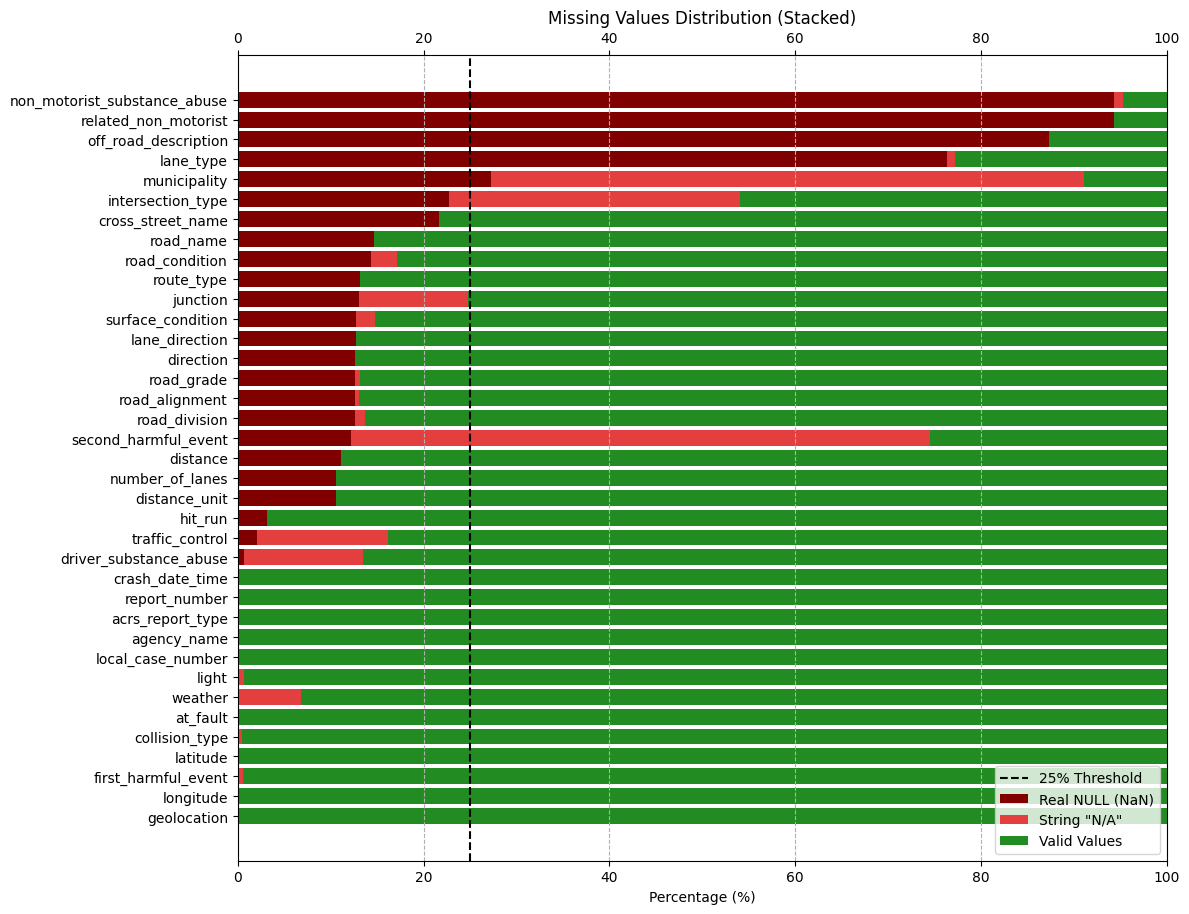

In [21]:
real_nulls = df.isna().sum() / len(df) * 100
string_nas = (df == "N/A").sum() / len(df) * 100
valid_vals = 100 - (real_nulls + string_nas)

# ארגון DataFrame לעבודה נוחה ולמיון
cols = df.columns
df_plot = pd.DataFrame({
    'real_nulls': real_nulls,
    'string_nas': string_nas,
    'valid_vals': valid_vals
}, index=cols)

# מיין לפי real_nulls יורד
df_plot_sorted = df_plot.sort_values('real_nulls', ascending=False)

y = np.arange(len(df_plot_sorted))

fig, ax = plt.subplots(figsize=(12, max(6, len(df_plot_sorted)*0.25)))

ax.barh(y, df_plot_sorted['real_nulls'], color='#800000', label='Real NULL (NaN)')
ax.barh(y, df_plot_sorted['string_nas'], left=df_plot_sorted['real_nulls'], color='#e43f3f', label='String "N/A"')
ax.barh(y, df_plot_sorted['valid_vals'], left=df_plot_sorted['real_nulls'] + df_plot_sorted['string_nas'], color='#228b22', label='Valid Values')


ax.axvline(x=25, color='black', linestyle='--', linewidth=1.5, label='25% Threshold')

ax.xaxis.set_ticks_position('both')
ax.tick_params(axis='x', which='both', labeltop=True, labelbottom=True)

ax.set_xlabel('Percentage (%)')
ax.set_title('Missing Values Distribution (Stacked)')
ax.set_yticks(y)
ax.set_yticklabels(df_plot_sorted.index)
ax.invert_yaxis() 
ax.set_xlim(0, 100)
ax.legend(loc='lower right', bbox_to_anchor=(1, 0))
ax.grid(axis='x', linestyle='--')

plt.tight_layout()
plt.show()


In [24]:
df.columns

Index(['report_number', 'local_case_number', 'agency_name', 'acrs_report_type',
       'crash_date_time', 'hit_run', 'route_type', 'lane_direction',
       'lane_type', 'number_of_lanes', 'direction', 'distance',
       'distance_unit', 'road_grade', 'road_name', 'at_fault',
       'collision_type', 'weather', 'surface_condition', 'light',
       'traffic_control', 'driver_substance_abuse', 'first_harmful_event',
       'second_harmful_event', 'junction', 'road_alignment', 'road_condition',
       'road_division', 'latitude', 'longitude', 'geolocation',
       'cross_street_name', 'intersection_type', 'off_road_description',
       'related_non_motorist', 'non_motorist_substance_abuse', 'municipality'],
      dtype='object')

In [34]:
df['second_harmful_event'].value_counts()

second_harmful_event
N/A                                72916
OTHER VEHICLE                      12114
FIXED OBJECT                        7180
PARKED VEHICLE                      2283
Not Applicable                      2258
                                   ...  
Bridge Rail                            1
Cable Barrier                          1
Jackknife                              1
Impact Attenuator/Crash Cushion        1
Railway Vehicle (train, engine)        1
Name: count, Length: 65, dtype: int64

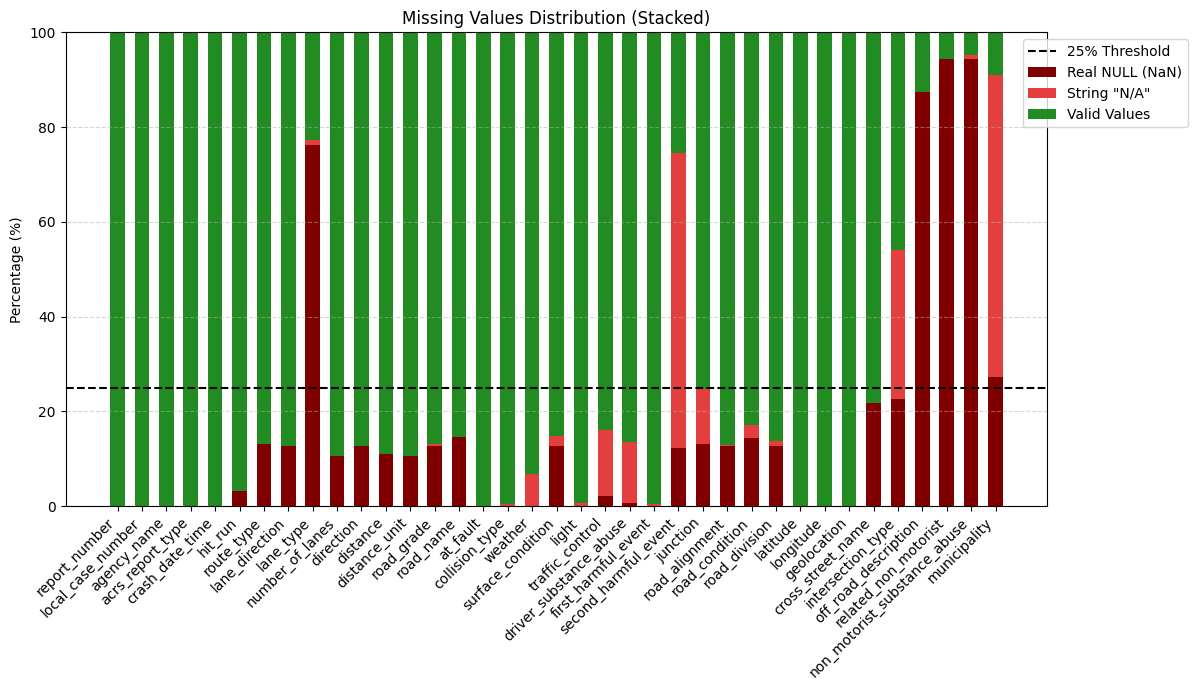

In [ ]:
real_nulls = df.isna().sum() / len(df) * 100
string_nas = (df == "N/A").sum() / len(df) * 100
valid_vals = 100 - (real_nulls + string_nas)

columns = df.columns
x = np.arange(len(columns))
width = 0.6 

fig, ax = plt.subplots(figsize=(12, 7))

p1 = ax.bar(x, real_nulls, width, label='Real NULL (NaN)', color='#800000')
p2 = ax.bar(x, string_nas, width, bottom=real_nulls, label='String "N/A"', color="#e43f3f")
p3 = ax.bar(x, valid_vals, width, bottom=real_nulls + string_nas, label='Valid Values', color='#228b22')

ax.axhline(y=25, color='black', linestyle='--', linewidth=1.5, label='25% Threshold')

ax.set_ylabel('Percentage (%)')
ax.set_title('Missing Values Distribution (Stacked)')
ax.set_xticks(x)
ax.set_xticklabels(columns, rotation=45, ha='right') 
ax.legend(loc='upper right', bbox_to_anchor=(1.15, 1)) 
ax.set_ylim(0, 100)
ax.grid(axis='y', linestyle='--', alpha=0.5) 

plt.tight_layout()
plt.show()

In [8]:
# Create a comprehensive data quality report
quality_report = pd.DataFrame({
    'Missing Values': df.isnull().sum(),
    'Missing %': round((df.isnull().sum() / len(df) * 100), 2),  
  #  'Unique Values': df.nunique(),
    'Data Type': df.dtypes
})

# Add descriptive statistics for numeric columns
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
for col in numeric_cols:
    quality_report.loc[col, 'Min'] = df[col].min()
    quality_report.loc[col, 'Max'] = df[col].max()
    quality_report.loc[col, 'Mean'] = round(df[col].mean(), 2) 

# Sort by missing values percentage
quality_report = quality_report.sort_values('Missing %', ascending=False)


quality_report

,Missing Values,Missing %,Data Type
non_motorist_substance_abuse,110187,94.34,object
related_non_motorist,110187,94.34,object
off_road_description,102023,87.35,object
lane_type,89288,76.45,object
municipality,31656,27.10,object
intersection_type,26375,22.58,object
cross_street_name,25213,21.59,object
road_name,17102,14.64,object
road_condition,16714,14.31,object
route_type,15441,13.22,object


In [17]:
df['intersection_type'].unique()

array([nan, 'Angled/Skewed', 'Perpendicular', 'Roundabout/Traffic Circle',
       'N/A', 'FOUR-WAY INTERSECTION', 'T-INTERSECTION',
       'FIVE-POINT OR MORE', 'OTHER', 'Y-INTERSECTION', 'ROUNDABOUT',
       'TRAFFIC CIRCLE', 'UNKNOWN'], dtype=object)

In [23]:
df['first_harmful_event'].value_counts()

first_harmful_event
OTHER VEHICLE                    66549
Motor Vehicle In Transport       13302
FIXED OBJECT                     11910
PARKED VEHICLE                    9392
PEDESTRIAN                        3802
                                 ...  
Units Separated                      2
Spilled Cargo                        2
Cargo/Equipment Loss Or Shift        2
Bridge Pier Or Support               1
Cable Barrier                        1
Name: count, Length: 68, dtype: int64

In [9]:
df.columns

Index(['report_number', 'local_case_number', 'agency_name', 'acrs_report_type',
       'crash_date_time', 'hit_run', 'route_type', 'lane_direction',
       'lane_type', 'number_of_lanes', 'direction', 'distance',
       'distance_unit', 'road_grade', 'at_fault', 'collision_type', 'weather',
       'surface_condition', 'light', 'traffic_control',
       'driver_substance_abuse', 'first_harmful_event', 'second_harmful_event',
       'junction', 'road_alignment', 'road_condition', 'road_division',
       'latitude', 'longitude', 'geolocation', ':@computed_region_vu5j_pcmz',
       ':@computed_region_tx5f_5em3', ':@computed_region_kbsp_ykn9',
       ':@computed_region_d7bw_bq6x', ':@computed_region_rbt8_3x7n',
       ':@computed_region_a9cs_3ed7', ':@computed_region_r648_kzwt',
       ':@computed_region_6vgr_duib', 'road_name', 'cross_street_name',
       'intersection_type', 'off_road_description', 'related_non_motorist',
       'non_motorist_substance_abuse', 'municipality'],
      dtype

In [14]:
df[[':@computed_region_vu5j_pcmz',
       ':@computed_region_tx5f_5em3', ':@computed_region_kbsp_ykn9',
       ':@computed_region_d7bw_bq6x', ':@computed_region_rbt8_3x7n',
       ':@computed_region_a9cs_3ed7', ':@computed_region_r648_kzwt',
       ':@computed_region_6vgr_duib']]

,:@computed_region_vu5j_pcmz,:@computed_region_tx5f_5em3,:@computed_region_kbsp_ykn9,:@computed_region_d7bw_bq6x,:@computed_region_rbt8_3x7n,:@computed_region_a9cs_3ed7,:@computed_region_r648_kzwt,:@computed_region_6vgr_duib
0,2,2,46,29,1,2,5,3
1,3,3,36,71,1,3,3,4
2,5,5,13,21,1,5,1,1
3,1,1,12,111,1,1,3,6
4,1,1,12,111,1,1,3,6
...,...,...,...,...,...,...,...,...
116790,4,4,58,58,1,4,4,3
116791,2,2,38,28,1,2,5,4
116792,3,3,61,58,1,3,4,2
116793,2,2,39,39,1,2,5,5
